In [1]:
from google.colab import drive

# Mount the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
import json

with open('/content/drive/MyDrive/Colab Notebooks/race_data.json', 'r') as file:
      data = json.load(file)

In [49]:
from google.colab import files
uploaded = files.upload()


In [4]:
print(data[135])

{'press_durations': [11.207095, 0.7724655, 1.049091, 1.0293508, 1.4643428, 1.0383544, 1.3960223, 0.739465, 1.5658915, 0.64845294, 0.7841835, 0.9685954, 0.62253237, 0.92599404, 0.3252785, 0.30108446, 0.0, 0.0, 0.13199149, 0.13599752, 0.0, 0.063168846], 'release_durations': [0.48384428, 0.20247497, 0.45569927, 0.44413477, 0.46189916, 0.37951958, 0.37256923, 0.19001713, 0.33048654, 0.23440807, 0.092294976, 0.2943926, 0.24929836, 0.22192365, 0.0, 0.016549185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'finish_time': '20.283'}


In [17]:
import json
import numpy as np

# Load the JSON data
with open('/content/drive/MyDrive/Colab Notebooks/race_data.json', 'r') as file:
    data = json.load(file)

# Extract press and release durations and finish times
press_durations = [record['press_durations'] for record in data]
release_durations = [record['release_durations'] for record in data]
finish_times = [record['finish_time'] for record in data]

# Determine the maximum length of press and release sequences
max_press_len = max(len(record) for record in press_durations)
max_release_len = max(len(record) for record in release_durations)

# Pad the sequences
def pad_sequences(sequences, maxlen, padding_value=0.0):
    return [seq + [padding_value] * (maxlen - len(seq)) if len(seq) < maxlen
            else seq[:maxlen] for seq in sequences]

padded_press_durations = pad_sequences(press_durations, max_press_len)
padded_release_durations = pad_sequences(release_durations, max_release_len)

# Combine press and release durations into a single input array
X = np.hstack((padded_press_durations, padded_release_durations))
y = np.array(finish_times)


In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam

# Sampling function for VAE as a custom Keras layer
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Network parameters
original_dim = X.shape[1]
intermediate_dim = 64
latent_dim = 32
batch_size = 16
epochs = 50

# Encoder
inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Sampling()([z_mean, z_log_var])

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim)
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model
vae = Model(inputs, x_decoded_mean)

# Compute VAE loss
reconstruction_loss = mse(inputs, x_decoded_mean) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer=Adam())

# Train VAE
vae.fit(X, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/50
7/7 [==============================] - 1s 30ms/step - loss: 164.8085 - val_loss: 135.3413
Epoch 2/50
7/7 [==============================] - 0s 8ms/step - loss: 125.4003 - val_loss: 109.4032
Epoch 3/50
7/7 [==============================] - 0s 9ms/step - loss: 104.1013 - val_loss: 89.6261
Epoch 4/50
7/7 [==============================] - 0s 8ms/step - loss: 87.5649 - val_loss: 76.2355
Epoch 5/50
7/7 [==============================] - 0s 7ms/step - loss: 74.0661 - val_loss: 61.6468
Epoch 6/50
7/7 [==============================] - 0s 7ms/step - loss: 59.8227 - val_loss: 47.0309
Epoch 7/50
7/7 [==============================] - 0s 10ms/step - loss: 52.0521 - val_loss: 43.9732
Epoch 8/50
7/7 [==============================] - 0s 7ms/step - loss: 45.5241 - val_loss: 38.2653
Epoch 9/50
7/7 [==============================] - 0s 7ms/step - loss: 41.5134 - val_loss: 33.5229
Epoch 10/50
7/7 [==============================] - 0s 7ms/step - loss: 38.5233 - val_loss: 31.1417
Epoch 11/50


In [54]:
# Build a separate decoder model
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)


In [59]:
class FinishTimeCallback(Callback):
    def __init__(self, decoder, latent_dim, n_samples=100):
        super(FinishTimeCallback, self).__init__()
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.n_samples = n_samples
        self.finish_times = []

    def on_epoch_end(self, epoch, logs=None):
        # Generate candidate sequences
        z_sample = np.random.normal(size=(self.n_samples, self.latent_dim))
        generated_sequences = self.decoder.predict(z_sample)

        # Separate the generated sequences into press and release durations
        generated_press_durations = np.maximum(generated_sequences[:, :max_press_len], 0.0)
        generated_release_durations = np.maximum(generated_sequences[:, max_press_len:], 0.0)

        # Simulate finish times for the generated sequences
        finish_times = [
            self.simulate_finish_time(generated_press_durations[i], generated_release_durations[i])
            for i in range(self.n_samples)
        ]

        # Calculate the best finish time for this epoch
        best_finish_time = min(finish_times)
        self.finish_times.append(best_finish_time)

        # Log the best finish time
        print(f'Epoch {epoch + 1}: Best Finish Time = {best_finish_time}')

    def simulate_finish_time(self, press_durations, release_durations):
        for i in range(len(press_durations)):
            print(press_durations[i],",")
        print("Release:")
        for i in range(len(release_durations)):
            print(release_durations[i],",")
        finish_time = input("Enter the finish time: ")
        return finish_time


In [60]:
# Instantiate the callback
finish_time_callback = FinishTimeCallback(decoder, latent_dim, n_samples=3)

# Train the VAE with the callback
vae.fit(X, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[finish_time_callback])


Epoch 1/250
1/1 [==============================] - 0s 21ms/step
10.395723 ,
0.631796 ,
0.44460398 ,
0.8058423 ,
2.3405464 ,
0.86011195 ,
0.7014215 ,
1.8113631 ,
0.3033638 ,
2.5208244 ,
0.33343244 ,
1.0024419 ,
0.32248235 ,
0.903543 ,
0.56045073 ,
0.11934732 ,
0.11949492 ,
0.0 ,
0.15161172 ,
0.051208355 ,
0.00926967 ,
0.0 ,
Release durations: 
[0.57087815 0.30596396 0.12785926 0.35958672 0.41268963 0.3638817
 0.35822242 0.19886135 0.25882423 0.15638939 0.13456352 0.
 0.20117903 0.3090216  0.         0.15115061 0.         0.
 0.         0.         0.17721057]
0.57087815 ,
0.30596396 ,
0.12785926 ,
0.35958672 ,
0.41268963 ,
0.3638817 ,
0.35822242 ,
0.19886135 ,
0.25882423 ,
0.15638939 ,
0.13456352 ,
0.0 ,
0.20117903 ,
0.3090216 ,
0.0 ,
0.15115061 ,
0.0 ,
0.0 ,
0.0 ,
0.0 ,
0.17721057 ,
Enter the finish time: 19.717
7.9893727 ,
0.757738 ,
0.79699266 ,
0.52116644 ,
1.8678604 ,
0.7062899 ,
0.40504962 ,
0.61621875 ,
1.4029205 ,
1.2267549 ,
0.6123066 ,
0.6421589 ,
0.3699012 ,
0.22120106 ,
0.096

KeyboardInterrupt: Interrupted by user

**4. Eredmények és elemzés**

In [22]:
import json
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam

# Define your Sampling layer
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Define your model parameters
original_dim = X.shape[1]
intermediate_dim = 64
latent_dim = 32
batch_size = 16
epochs_list = [50, 250, 1000]

# Function to create and compile the VAE model
def create_vae():
    inputs = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    z = Sampling()([z_mean, z_log_var])
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim)
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)
    vae = Model(inputs, x_decoded_mean)
    reconstruction_loss = mse(inputs, x_decoded_mean) * original_dim
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer=Adam())
    return vae

# Training the model for different epochs and saving the histories
for epochs in epochs_list:
    vae = create_vae()
    history = vae.fit(X, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    with open(f'training_history_{epochs}.json', 'w') as f:
        json.dump(history.history, f)


Epoch 1/50
7/7 [==============================] - 1s 33ms/step - loss: 311.0814 - val_loss: 214.0117
Epoch 2/50
7/7 [==============================] - 0s 7ms/step - loss: 187.7860 - val_loss: 153.1401
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 143.6976 - val_loss: 120.5237
Epoch 4/50
7/7 [==============================] - 0s 8ms/step - loss: 121.3500 - val_loss: 105.0275
Epoch 5/50
7/7 [==============================] - 0s 7ms/step - loss: 106.1154 - val_loss: 87.2735
Epoch 6/50
7/7 [==============================] - 0s 6ms/step - loss: 91.0674 - val_loss: 73.3818
Epoch 7/50
7/7 [==============================] - 0s 6ms/step - loss: 76.8885 - val_loss: 62.9196
Epoch 8/50
7/7 [==============================] - 0s 7ms/step - loss: 63.9634 - val_loss: 52.7823
Epoch 9/50
7/7 [==============================] - 0s 9ms/step - loss: 56.4036 - val_loss: 45.0716
Epoch 10/50
7/7 [==============================] - 0s 7ms/step - loss: 51.2266 - val_loss: 40.5815
Epoch 11

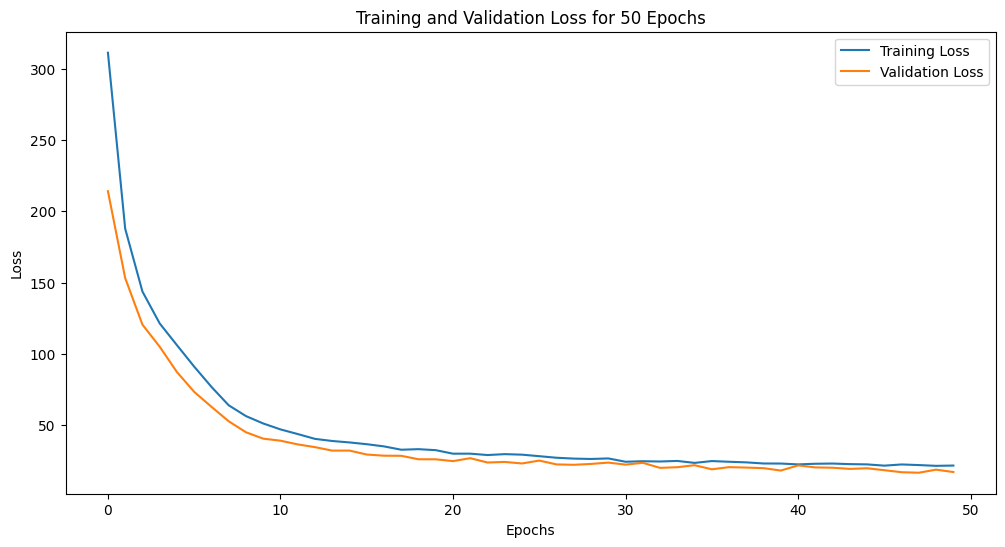

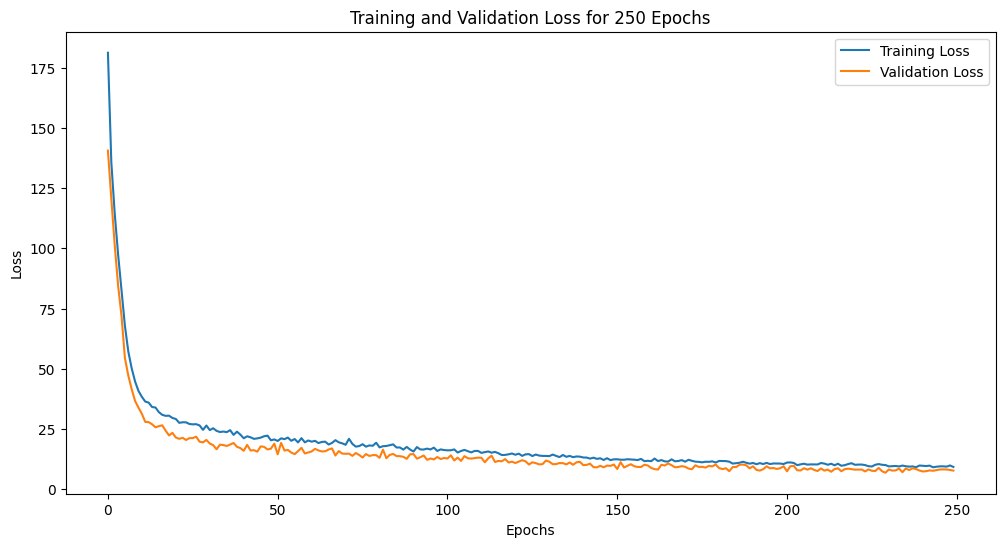

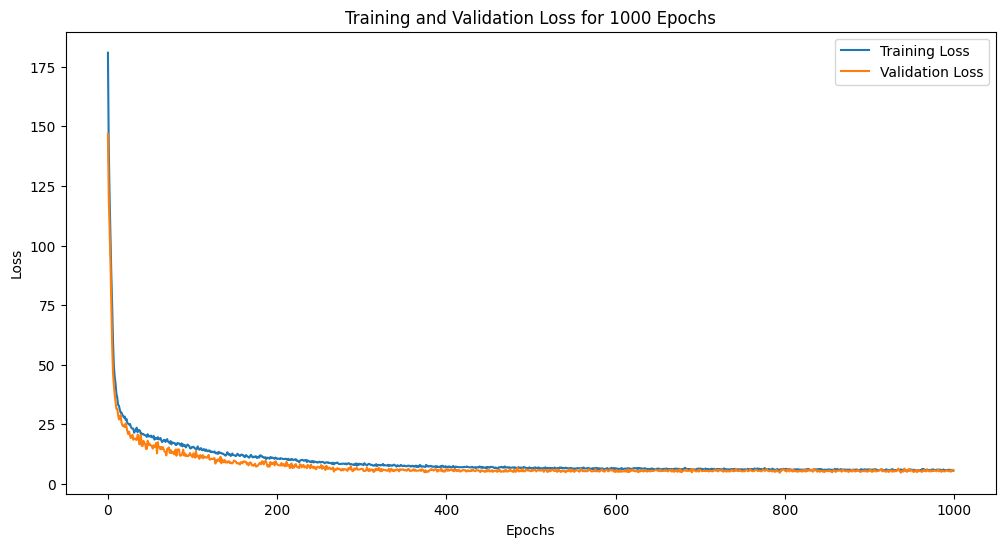

In [23]:
import matplotlib.pyplot as plt

def plot_training_history(epochs):
    with open(f'training_history_{epochs}.json', 'r') as f:
        history = json.load(f)

    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {epochs} Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the training history for 50, 250, and 1000 epochs
for epochs in epochs_list:
    plot_training_history(epochs)
